# CLARITY-SemEval 2026 · Step 1 Data Analysis

Understand the QEvasion dataset before modeling by inspecting schema, data quality, and core class distributions.

## Imports & Plotting Setup

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import shorten
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

sns.set_theme(style='whitegrid', context='talk')
pd.options.display.max_columns = 20

## Load the QEvasion Dataset

Attempts to read the cached CSV under `../data/raw`. If it does not exist locally the HuggingFace copy is downloaded (matching the repo instructions).

In [29]:
DATA_PATH = Path('../data/raw/QEvasion.csv')
HF_DATASET = 'ailsntua/QEvasion'

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
else:
    from datasets import load_dataset
    dataset = load_dataset(HF_DATASET, split='train')
    df = dataset.to_pandas()
    DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(DATA_PATH, index=False)

print(f'Total rows: {len(df):,}')
df.head()

Total rows: 3,448


,title,date,president,url,question_order,interview_question,interview_answer,gpt3.5_summary,gpt3.5_prediction,question,annotator_id,annotator1,annotator2,annotator3,inaudible,multiple_questions,affirmative_questions,index,clarity_label,evasion_label
0,"The President's News Conference in Hanoi, Vietnam","September 10, 2023",Joseph R. Biden,https://www.presidency.ucsb.edu/documents/the-...,1,Q. Of the Biden administration. And accused th...,"Well, look, first of all, theI am sincere abou...",The question consists of 2 parts: \n1. How wou...,Question part: 1. How would you respond to the...,How would you respond to the accusation that t...,85,NaN,NaN,NaN,False,False,False,0,Clear Reply,Explicit
1,"The President's News Conference in Hanoi, Vietnam","September 10, 2023",Joseph R. Biden,https://www.presidency.ucsb.edu/documents/the-...,1,Q. Of the Biden administration. And accused th...,"Well, look, first of all, theI am sincere abou...",The question consists of 2 parts: \n1. How wou...,Question part: 1. How would you respond to the...,Do you think President Xi is being sincere abo...,85,NaN,NaN,NaN,False,False,False,1,Ambivalent,General
2,"The President's News Conference in Hanoi, Vietnam","September 10, 2023",Joseph R. Biden,https://www.presidency.ucsb.edu/documents/the-...,2,Q. No worries. Do you believe the country's sl...,"Look, I think China has a difficult economic p...",The question consists of two parts:\n\n1. Q1: ...,Question part: Q1 - Do you believe the country...,Do you believe the country's slowdown and gro...,85,NaN,NaN,NaN,False,False,False,2,Ambivalent,Partial/half-answer
3,"The President's News Conference in Hanoi, Vietnam","September 10, 2023",Joseph R. Biden,https://www.presidency.ucsb.edu/documents/the-...,2,Q. No worries. Do you believe the country's sl...,"Look, I think China has a difficult economic p...",The question consists of two parts:\n\n1. Q1: ...,Question part: Q1 - Do you believe the country...,Are you worried about the meeting between Pre...,85,NaN,NaN,NaN,False,False,False,3,Ambivalent,Dodging
4,"The President's News Conference in Hanoi, Vietnam","September 10, 2023",Joseph R. Biden,https://www.presidency.ucsb.edu/documents/the-...,3,"Q. I can imagine. It is evening, I'd like to r...","Well, I hope I get to see Mr. Xi sooner than l...",The question consists of 3 parts:\n1. Is the P...,Question part: 1. Is the President's engagemen...,Is the President's engagement with Asian coun...,85,NaN,NaN,NaN,False,False,False,4,Clear Reply,Explicit


## Column Cleanup & Date Simplification

Drop annotation-only columns, retain the multiple-question flag as a boolean, and convert the interview date to a year value for easier grouping.

In [30]:
DROP_COLS = [
    'annotator_id', 'annotator1', 'annotator2', 'annotator3',
    'inaudible', 'multiple_questions', 'affirmative_questions',
    'index', 'question_order', 'url'
]

if 'multiple_questions' in df.columns:
    df['has_multiple_questions'] = (df['multiple_questions']
                                     .astype(str)
                                     .str.lower()
                                     .isin(['true', '1']))
else:
    df['has_multiple_questions'] = False

if 'date' in df.columns:
    df['interview_year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
    df = df.drop(columns=['date'])

df = df.drop(columns=DROP_COLS, errors='ignore')
print(f'Remaining columns: {len(df.columns)}')
df[['title', 'interview_year', 'clarity_label', 'evasion_label']].head()

Remaining columns: 11


,title,interview_year,clarity_label,evasion_label
0,"The President's News Conference in Hanoi, Vietnam",2023,Clear Reply,Explicit
1,"The President's News Conference in Hanoi, Vietnam",2023,Ambivalent,General
2,"The President's News Conference in Hanoi, Vietnam",2023,Ambivalent,Partial/half-answer
3,"The President's News Conference in Hanoi, Vietnam",2023,Ambivalent,Dodging
4,"The President's News Conference in Hanoi, Vietnam",2023,Clear Reply,Explicit


## High-Level Metadata

In [33]:
column_summary = (
    pd.DataFrame({
        'dtype': df.dtypes,
        'example_value': df.apply(
            lambda col: shorten(
                str(col.dropna().iloc[0]),
                width=80,
                placeholder='…'
            ) if col.notna().any() else '—'
        )
    })
).head(20)


info_table = pd.DataFrame({
    'records': [len(df)],
    'unique_titles': [df['title'].nunique()],
    'unique_presidents': [df['president'].nunique()],
})

display(info_table)
display(column_summary)

,records,unique_titles,unique_presidents
0,3448,175,4


,dtype,example_value
title,object,"The President's News Conference in Hanoi, Vietnam"
president,object,Joseph R. Biden
interview_question,object,Q. Of the Biden administration. And accused th...
interview_answer,object,"Well, look, first of all, theI am sincere abou..."
gpt3.5_summary,object,The question consists of 2 parts: 1. How would...
gpt3.5_prediction,object,Question part: 1. How would you respond to the...
question,object,How would you respond to the accusation that t...
clarity_label,object,Clear Reply
evasion_label,object,Explicit
has_multiple_questions,bool,False


## Missingness Snapshot

In [34]:
missing = (df.isna().sum().to_frame('missing_count')
          .assign(missing_pct=lambda x: (x['missing_count'] / len(df) * 100).round(2))
          .query('missing_count > 0')
          .sort_values('missing_count', ascending=False))
missing.head(15)

,missing_count,missing_pct


## Feature Engineering for Exploration

In [35]:
df = df.copy()
df['answer_word_count'] = df['interview_answer'].fillna('').str.split().str.len()
df['question_word_count'] = df['interview_question'].fillna('').str.split().str.len()
if 'has_multiple_questions' not in df.columns:
    df['has_multiple_questions'] = False

summary_stats = df[['answer_word_count', 'question_word_count']].describe().round(1)
summary_stats

,answer_word_count,question_word_count
count,3448.0,3448.0
mean,293.6,61.5
std,301.5,59.9
min,1.0,3.0
25%,56.0,22.0
50%,207.0,50.0
75%,440.0,82.0
max,2117.0,780.0


## Clarity Label Distribution

/tmp/ipykernel_346399/1099618597.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=clarity_counts, x='clarity_label', y='count', palette='viridis')


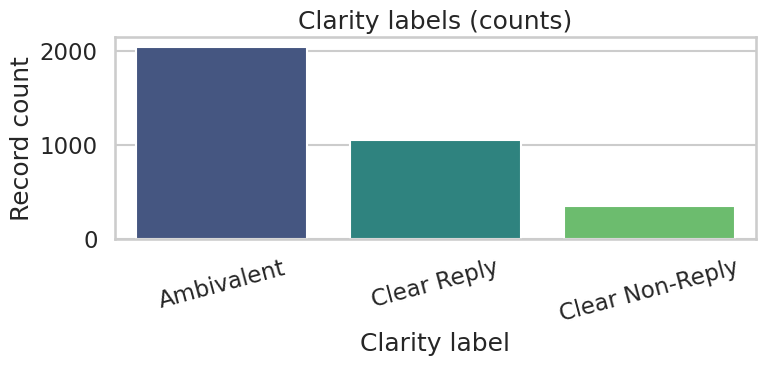

,clarity_label,count,percent
0,Ambivalent,2040,59.16
1,Clear Reply,1052,30.51
2,Clear Non-Reply,356,10.32


In [36]:
clarity_counts = df['clarity_label'].value_counts().rename_axis('clarity_label').reset_index(name='count')
plt.figure(figsize=(8,4))
sns.barplot(data=clarity_counts, x='clarity_label', y='count', palette='viridis')
plt.title('Clarity labels (counts)')
plt.xlabel('Clarity label')
plt.ylabel('Record count')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
clarity_counts.assign(percent=lambda x: (x['count']/len(df)*100).round(2))

## Top Evasion Techniques

/tmp/ipykernel_346399/1195627548.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=evasion_counts.head(top_k), x='count', y='evasion_label', palette='magma')


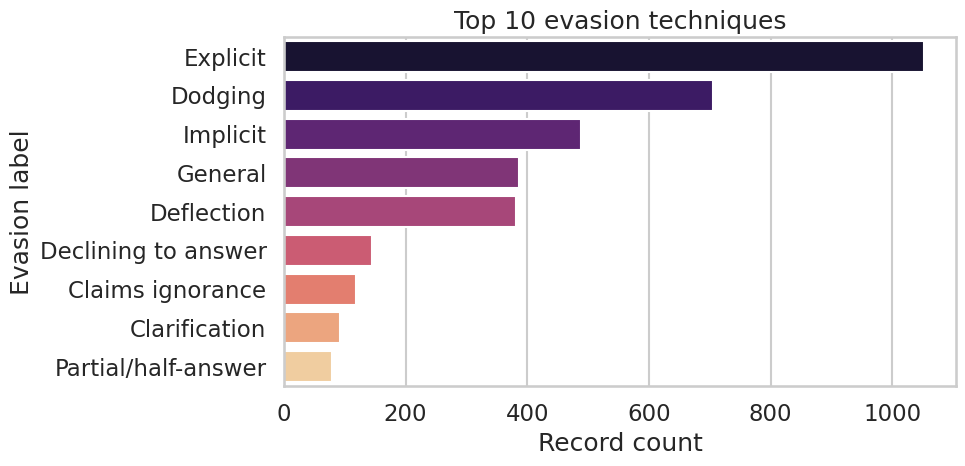

,evasion_label,count,percent
0,Explicit,1052,30.51
1,Dodging,706,20.48
2,Implicit,488,14.15
3,General,386,11.19
4,Deflection,381,11.05
5,Declining to answer,145,4.21
6,Claims ignorance,119,3.45
7,Clarification,92,2.67
8,Partial/half-answer,79,2.29


In [37]:
top_k = 10
evasion_counts = df['evasion_label'].value_counts().reset_index()
evasion_counts.columns = ['evasion_label', 'count']
plt.figure(figsize=(10,5))
sns.barplot(data=evasion_counts.head(top_k), x='count', y='evasion_label', palette='magma')
plt.title(f'Top {top_k} evasion techniques')
plt.xlabel('Record count')
plt.ylabel('Evasion label')
plt.tight_layout()
plt.show()
evasion_counts.assign(percent=lambda x: (x['count']/len(df)*100).round(2)).head(top_k)

## Answer Length Distribution

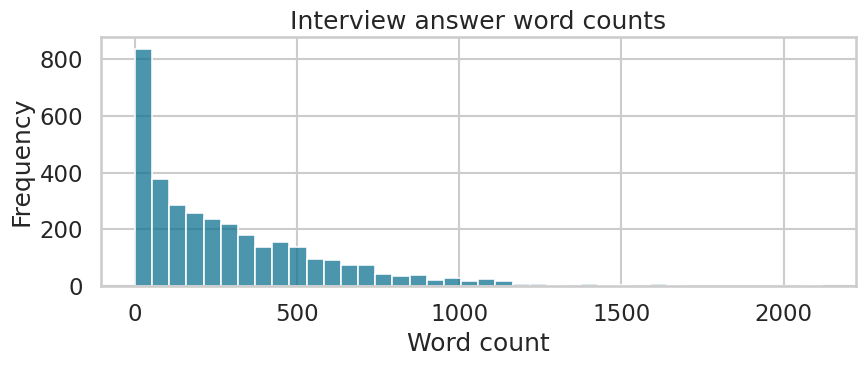

In [39]:
plt.figure(figsize=(9,4))
sns.histplot(df, x='answer_word_count', bins=40, color='#0f7391')
plt.title('Interview answer word counts')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Question vs. Answer Length

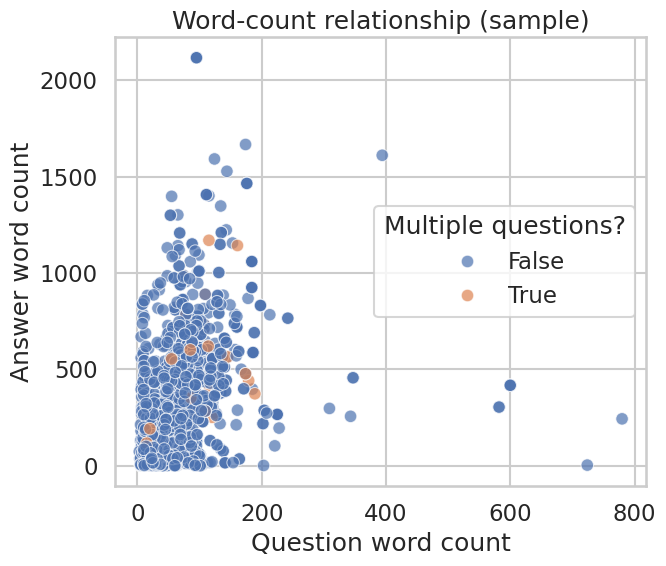

In [40]:
plt.figure(figsize=(7,6))
sns.scatterplot(data=df.sample(min(1500, len(df)), random_state=42),
                x='question_word_count', y='answer_word_count',
                hue='has_multiple_questions', palette='deep', alpha=0.7)
plt.title('Word-count relationship (sample)')
plt.xlabel('Question word count')
plt.ylabel('Answer word count')
plt.legend(title='Multiple questions?')
plt.tight_layout()
plt.show()

## Clarity vs. Evasion Cross-Tab

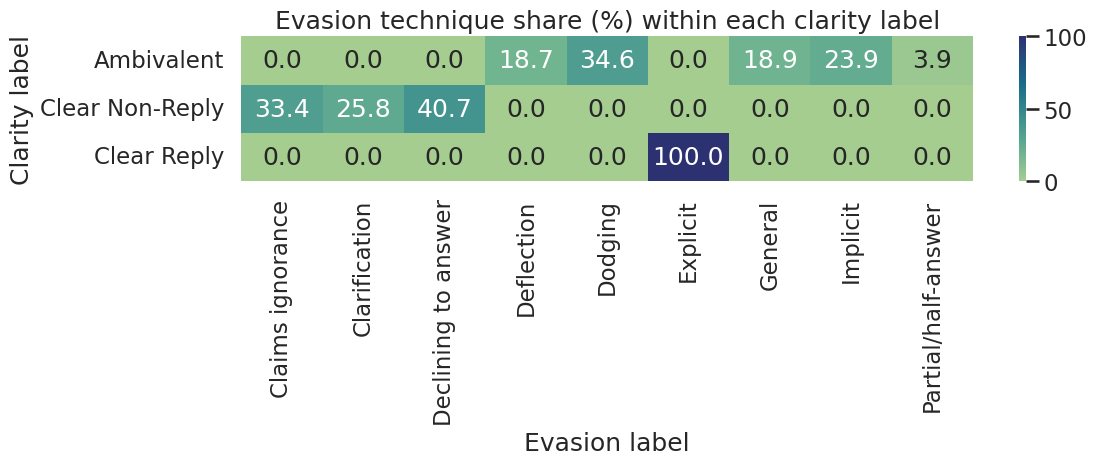

In [41]:
crosstab = (pd.crosstab(df['clarity_label'], df['evasion_label'])
            .div(df['clarity_label'].value_counts(), axis=0) * 100)
plt.figure(figsize=(12,5))
sns.heatmap(crosstab, annot=True, fmt='.1f', cmap='crest')
plt.title('Evasion technique share (%) within each clarity label')
plt.xlabel('Evasion label')
plt.ylabel('Clarity label')
plt.tight_layout()
plt.show()

## Single vs. Multi-Question Items

/tmp/ipykernel_346399/1291111816.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=multi_counts, x='multiple_questions', y='count', palette='Set2')


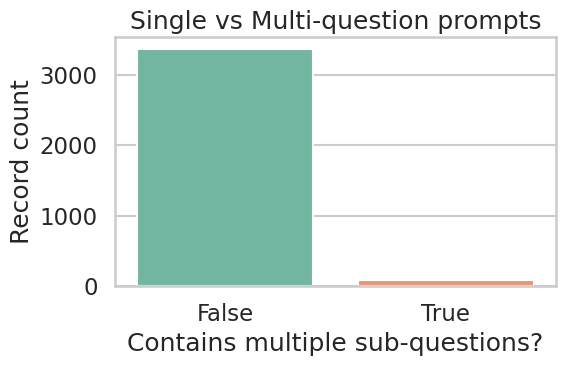

,multiple_questions,count,percent
0,False,3362,97.51
1,True,86,2.49


In [42]:
multi_counts = df['has_multiple_questions'].value_counts().rename_axis('multiple_questions').reset_index(name='count')
plt.figure(figsize=(6,4))
sns.barplot(data=multi_counts, x='multiple_questions', y='count', palette='Set2')
plt.title('Single vs Multi-question prompts')
plt.xlabel('Contains multiple sub-questions?')
plt.ylabel('Record count')
plt.tight_layout()
plt.show()
multi_counts.assign(percent=lambda x: (x['count']/len(df)*100).round(2))

## Baseline Clarity Classification

A lightweight pipeline that concatenates questions and answers, applies TF-IDF features, and trains a class-balanced logistic regression classifier for the 3-way clarity prediction.

In [43]:
model_df = df.dropna(subset=['clarity_label']).copy()
model_df['text'] = (model_df['interview_question'].fillna('') + ' ' +
                    model_df['interview_answer'].fillna(''))

X_train, X_test, y_train, y_test = train_test_split(
    model_df['text'],
    model_df['clarity_label'],
    test_size=0.2,
    stratify=model_df['clarity_label'],
    random_state=42
)

clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=25000, ngram_range=(1, 2), min_df=5)),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
report = classification_report(y_test, preds, output_dict=True)
print('Validation accuracy:', (preds == y_test).mean().round(3))
pd.DataFrame(report).transpose().round(3)

Validation accuracy: 0.574


,precision,recall,f1-score,support
Ambivalent,0.696,0.623,0.657,408.000
Clear Non-Reply,0.396,0.563,0.465,71.000
Clear Reply,0.455,0.483,0.469,211.000
accuracy,0.574,0.574,0.574,0.574
macro avg,0.516,0.556,0.530,690.000
weighted avg,0.591,0.574,0.580,690.000
